In [136]:
import pandas as pd
import numpy as np
import os
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import sklearn as sk
import tensorflow as tf
import matplotlib.pyplot as plt
#'width': 640, 'height': 480
# %%

In [97]:

datasets = []

data_folders = glob('./course_dataset/ASL_*')
list_df = [pd.read_csv(os.path.join(folder,'annotations.csv'),index_col='ID') for folder in data_folders]

list_df

for letter_df in list_df:
    dataset  = []
    ## get label
    label = letter_df.gesture.iloc[0]
    ## Remove 'hand_position'
    df = letter_df.drop(letter_df[letter_df.joint == 'hand_position'].index,)


In [ ]:
for letter_df in list_df:
    dataset  = []
    ## get label
    label = letter_df.gesture.iloc[0].split("_")[-1]

    ## Remove 'hand_position'
    df = letter_df.drop(letter_df[letter_df.joint == 'hand_position'].index,)

    # ------- TO DO ---------
    # Normalize x and y

    # Append joints coordinates and letter for each frame of each video
    for video_id in df.video_idx.unique():
        video_df = df[df.video_idx == video_id]
        for frame in video_df.frame.unique():
            frame_df = video_df[video_df.frame == frame]
            dataset.append([frame_df[["x","y"]].to_numpy().tolist(),label])
    datasets.append(dataset)



In [116]:


#%%
all = list_df[0].copy()
for i in range(1,len(list_df)):
    all = all.append(list_df[i])

# %%
ds_train = []
ds_test = []

for ds in datasets:
    train,test = train_test_split(ds,test_size=.3)
    ds_train += train
    ds_test += test

# %%
X_train = np.array([train[0] for train in ds_train])
Y_train = np.array([train[1] for train in ds_train])

X_train,X_val,Y_train,Y_val = train_test_split(X_train,Y_train,test_size=.2)

X_train,Y_train = shuffle(X_train,Y_train)

X_test = np.array([test[0] for test in ds_test])
Y_test = np.array([test[1] for test in ds_test])

# One-Hot encode the labels for training
encoder = sk.preprocessing.OneHotEncoder(dtype=np.float32)
encoder.fit(Y_train.reshape((-1, 1)))

Y_train_encoded = encoder.transform(Y_train.reshape((-1, 1))).toarray()
Y_val_encoded = encoder.transform(Y_val.reshape((-1, 1))).toarray()
Y_test_encoded = encoder.transform(Y_test.reshape((-1, 1))).toarray()


Train on 57324 samples, validate on 14332 samples
Epoch 1/5
57324/57324 [==============================] - 3s 50us/sample - loss: 1.3056 - categorical_accuracy: 0.9436 - val_loss: 0.0196 - val_categorical_accuracy: 0.9967
Epoch 2/5
57324/57324 [==============================] - 2s 40us/sample - loss: 0.0202 - categorical_accuracy: 0.9948 - val_loss: 0.0046 - val_categorical_accuracy: 0.9991
Epoch 3/5
57324/57324 [==============================] - 2s 39us/sample - loss: 0.0052 - categorical_accuracy: 0.9982 - val_loss: 0.0042 - val_categorical_accuracy: 0.9984
Epoch 4/5
57324/57324 [==============================] - 2s 41us/sample - loss: 0.0011 - categorical_accuracy: 0.9999 - val_loss: 5.2816e-04 - val_categorical_accuracy: 1.0000
Epoch 5/5
57324/57324 [==============================] - 2s 41us/sample - loss: 5.2794e-04 - categorical_accuracy: 1.0000 - val_loss: 3.4257e-04 - val_categorical_accuracy: 1.0000


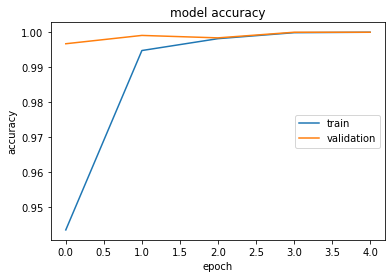

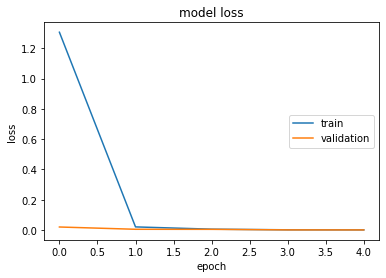

The train accuracy is 100.0 %
The test accuracy is 100.0 %


In [180]:

model = tf.keras.models.Sequential(
    layers= [
        tf.keras.layers.Input(shape=(20,2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(100, activation="relu"),
        tf.keras.layers.Dense(50, activation="relu"),
        tf.keras.layers.Dense(20, activation="relu"),
        tf.keras.layers.Dense(6, activation="softmax"),
    ]
)

model.compile(
optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
loss=tf.keras.losses.CategoricalCrossentropy(),
metrics=[tf.keras.metrics.CategoricalAccuracy()])
    

history=model.fit(x=X_train,
          y=Y_train_encoded,
          validation_data = (X_val,Y_val_encoded),
          batch_size=100,
          epochs=5,
         )

plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='center right')
plt.show()
 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='center right')
plt.show()

_,train_accuracy= model.evaluate(X_train, Y_train_encoded, verbose=0)
print("The train accuracy is", train_accuracy*100,"%")

_,test_accuracy = model.evaluate(X_test, Y_test_encoded,verbose=0)
print("The test accuracy is" , test_accuracy * 100 , "%")

